<font face="黑体" size=4 color=#8B0000> 美林时钟模型资产配置回测 </font>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir("D:\各种材料\研究生\公众号\三、美林时钟模型")

<font size=4 color ='08#0000' face='黑体'>获得用于周期判断的产出缺口和CPI同比</font>

Text(0, 0.5, 'CPI同比')

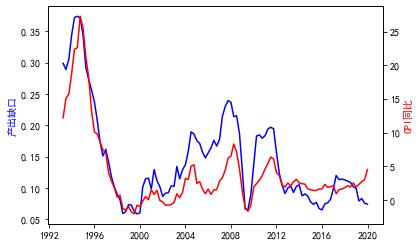

In [4]:
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei'] # for the normal demonstration of chinese words
#china=pd.read_excel('中国经济一致指数通胀滤波.xlsx')
china=pd.read_excel('中国GDPCPI同比.xlsx')
eco=china['产出缺口']
cpi=china['CPI同比']
x=china['日期']
fig,ax1=plt.subplots()
ax2=ax1.twinx()
ax1.plot(x,eco,color='b')
ax2.plot(x,cpi,color='r')
ax1.set_ylabel("产出缺口",color="b")
ax2.set_ylabel("CPI同比",color="r")

<font size=4 color ='08#0000' face='黑体'>获得周期信号</font>

In [5]:
def Circle_Identify(D):
    #The function is to identify the circle in American Investment Clock Model
    #D is DataFrame
    eco=D['产出缺口']
    cpi=D['CPI同比']
    eco_s=np.sign(D['产出缺口']-D['产出缺口'].shift(1))
    cpi_s=np.sign(D['CPI同比']-D['CPI同比'].shift(1))
    eco_signal=np.sign(eco_s*eco_s.shift(-1))# 1: trend no change; -1: trend change
    cpi_signal=np.sign(cpi_s*cpi_s.shift(-1))# 1: trend no change; -1: trend change
    eco_pos=eco_signal[eco_signal==-1].index.tolist()  #the position where the gdp trend changes  
    cpi_pos=cpi_signal[cpi_signal==-1].index.tolist()  #the position where the cpi trend changes
    change=set(cpi_pos+eco_pos) 
    change=list(change)# the index where the change happened
    change.sort()
    circle_type=[]#record the type of the circle 0: recovery, 1:overheat, 2:stagflation, 3:decline
    for pos in range(0,len(change)):
        compare=D.iloc[change[pos]][0:3]-D.iloc[change[pos]-1][0:3] 
        if (change[pos] in eco_pos and change[pos] in cpi_pos ):#both the gdp & cpi trend change
            if ((compare['产出缺口']<0)&(compare['CPI同比']<0)): #later the gdp grows, cpi grows, overheat:1 
                circle_type.append(1) #recording the circle type of the next period
            elif((compare['产出缺口']<0)&(compare['CPI同比']>0)):#later the gdp grows, cpi decrease, recovery:0
                circle_type.append(0)
            elif((compare['产出缺口']>0)&(compare['CPI同比']>0)):#later the gdp decrease, cpi deccrease,decline:3 
                circle_type.append(3)
            else:
                circle_type.append(2) #later the gdp decrease, cpi grows, stagflation: 2
        else:#single signal trend change
            if change[pos] in eco_pos: #gdp trend change, cpi trend stays
                if ((compare['产出缺口']<0)&(compare['CPI同比']<=0)): #later the gdp grows, cpi decrease, recovery:0 
                    circle_type.append(0) #recording the circle type of the next period
                elif((compare['产出缺口']<0)&(compare['CPI同比']>=0)):#later the gdp grows, cpi grows, overheat:1 
                    circle_type.append(1)
                elif((compare['产出缺口']>0)&(compare['CPI同比']>=0)):#later the gdp decrease, cpi grows,stagflation: 2 
                    circle_type.append(2)
                else:
                    circle_type.append(3) #later the gdp decrease, cpi grows, decline:3
            else: #cpi treend change
                if ((compare['产出缺口']<0)&(compare['CPI同比']<0)): #later the gdp decreases, cpi grows,stagflation: 2  
                    circle_type.append(2) #recording the circle type of the next period
                elif((compare['产出缺口']<0)&(compare['CPI同比']>0)):#later the gdp decreases, cpi decreases,decline:3 
                    circle_type.append(3)
                elif((compare['产出缺口']>0)&(compare['CPI同比']>0)):#later the gdp grows, cpi decreases,recovery: 0
                    circle_type.append(0)
                else:
                    circle_type.append(1) #later the gdp grows, cpi grows, overheat:1     
    return [change,circle_type]

In [7]:
clock_china=[x,eco,cpi]
clock_china=pd.concat(clock_china, axis=1)
[change,circle_type]= Circle_Identify(clock_china)# change: record the index of circle change in the china; circle_type: record the circle type

<font size=4 color ='08#0000' face='黑体'>导入大类资产价格</font>

In [8]:
price=pd.read_excel('资产价格.xlsx','中国')
price.index=price['日期']
del price['日期']
price=price.dropna(0)#去除包含NaN的行
price

,沪深300,中债-新综合净价(总值)指数,南华商品指数,货币基金
日期,,,,
2004-06-30,1078.4850,96.2277,1007.1169,963.9150
2004-07-30,1088.6770,96.5451,965.7056,965.7887
2004-08-31,1055.9700,96.3873,979.0981,967.8995
2004-09-30,1109.3240,96.0118,996.9959,969.9913
2004-10-29,1050.2990,95.9732,958.4566,971.9698
...,...,...,...,...
2019-09-30,3814.5282,100.2526,1470.2700,1540.3365
2019-10-31,3886.7519,99.8088,1462.8200,1543.5310
2019-11-29,3828.6706,100.2544,1473.2500,1546.5647


In [9]:
#将日期都处理为仅为月度数据
clock_china['日期']= clock_china['日期'].map(lambda a : a.strftime('%Y-%m')) 
price.index=price.index.map(lambda a: a.strftime('%Y-%m'))

<font face='黑体' size= 4 color=#8B0000 >回测实现 </font>

In [10]:
def period_return(d1,d2,circle,D):
    #d1,d2是持有资产的起始和终止日期
    if circle==0:
        asset='沪深300'
    elif circle==1:
        asset='南华商品指数'
    elif circle==2:
        asset='货币基金'
    else:
        asset='中债-新综合净价(总值)指数'
    asset_choose=D[asset][d1:d2]#选中投资资产
    temp_r=asset_choose/asset_choose.shift(1)-1
    temp_r=temp_r.dropna()
    date=list(temp_r.index)
    ret=list(temp_r.values)
    #返回整个时间段内的各资产收益率的排名情况，并返回所选择资产的总收益率排名
    P=D[d1:d2]#获得所有资产该段时间的价格
    r_period=P.iloc[-1]/P.iloc[0]-1#计算各资产的收益率
    if r_period[asset]>0:
        SelectPos=1 #即选中了收益率大于零的资产
    else:
        SelectPos=0
    temp_r=r_period.sort_values(ascending=False)#收益率排序
    assetrank=list(temp_r.index)#按收益率从高到低的资产名称
    rank=assetrank.index(asset)+1#得到4类资产中的排名
    return [ret,date,assetrank,asset,rank,SelectPos] #ret 从起始日之后的第一期记录，日期也是。

In [11]:
testdate=[]#record the asset changing day/monthly
r=[]#record the return/ monthly

changedate=[]#记录周期类型改变的日期
assetrank=[]#记录这段期间各资产收益率排名（降序）
assetselect=[]#记录选择的资产
SelectRank=[]#记录所选择资产的收益率排名
RightOrWrong=[] #是否选择了收益为正的资产

for nbr in  range(len(change)): 
    if clock_china['日期'][change[nbr]] in price.index:
        circletype=circle_type[nbr]
        changedate.append(clock_china['日期'][change[nbr]])
        if (nbr< len(change)-1):
            res=period_return(clock_china['日期'][change[nbr]],clock_china['日期'][change[nbr+1]],circletype,price)
            temp_r=res[0]
            temp_d=res[1]
        else:
            res=period_return(clock_china['日期'][change[nbr]],price.index[-1],circletype,price)
            temp_r=res[0]
            temp_d=res[1]
        r=r+temp_r #直接将收益率列表合并了
        testdate=testdate+temp_d
        assetrank.append(res[2])
        assetselect.append([res[3]])
        SelectRank.append(res[4])
        RightOrWrong.append(res[5])
    else:
        ;
    nbr=nbr+1 

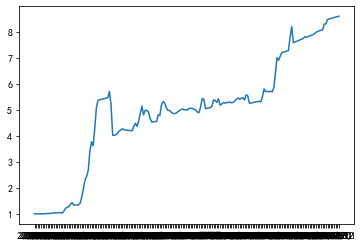

In [12]:
r_plus1=np.array(r)+1
nav=np.cumprod(r_plus1)
nav=pd.DataFrame(nav,index=testdate,columns=['净值'])
start_date=changedate[0]
nav.loc[start_date]=1
nav=nav.sort_index()
plt.plot(nav)

In [15]:
circle_type=pd.DataFrame(circle_type,index=clock_china['日期'][change],columns=['周期类型'])
writer=pd.ExcelWriter("中国直接用GDP.xlsx")
nav.to_excel(writer,'净值',float_format='%.5f')
circle_type.to_excel(writer,'周期类型',float_format='%.5f')

#回测过程具体信息
assetrank=pd.DataFrame(assetrank,index=changedate,columns=['1st','2nd','3rd','4th'])
assetselect=pd.DataFrame(assetselect,index=changedate,columns=['所选资产'])
SelectRank=pd.DataFrame(SelectRank,index=changedate,columns=['所选资产排名'])
RightOrWrong=pd.DataFrame(RightOrWrong,index=changedate,columns=['所选资产收益率是否为正'])
res=pd.concat([assetrank,assetselect,SelectRank,RightOrWrong],axis=1)
res.to_excel(writer,'回测过程',float_format='%.5f')
writer.save()

<font face='黑体' size= 4 color=#8B0000 >相关指标 </font>

In [16]:
whole_return=nav.values
annual_return=(whole_return[-1])**(12/len(whole_return))-1
print('年化收益率',annual_return)

#计算年化波动率
import math
annual_vol=r_plus1.std()*math.sqrt(12)
print('年化波动率',annual_vol)

#计算夏普比率
print('夏普比率',(annual_return/annual_vol))

#计算最大回撤
return_list=whole_return
max_turndown=((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list)).max()
print('最大回撤',max_turndown)

#计算Calmar值
calmar=annual_return/max_turndown
print('Calmar',calmar)

年化收益率 [0.14718627]
年化波动率 0.16613793533770754
夏普比率 [0.88592811]
最大回撤 0.2951325277707949
Calmar [0.49871245]
